# NESBA acoustic telescope locations

finding range and depth positions of AT and TM4

In [1]:
import sandbox as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy

### Load netcdf file

In [3]:
filePath = '/Users/ivanaescobar/work/sandbox/at_2020_11_4/Bellhop/nesba/'
runName = 'nesba-tm4'
if (os.uname()[0] == 'Linux'):
    filePath = '/scratch2/ivana/regionalgcm/bellhop-nesba/'
    runName = 'nesba-tm4_sverdrup'

In [4]:
ds = xr.open_dataset(filePath + runName + '.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:  (r: 41, z: 1001)
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 31 32 33 34 35 36 37 38 39 40
  * z        (z) int64 0 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
Data variables:
    range    (r) float64 ...
    depth    (r) float64 ...
    lat      (r) float64 ...
    lon      (r) float64 ...
    salt     (z, r) float64 ...
    temp     (z, r) float64 ...
    ss       (z, r) float64 ...
    ssmod1   (z, r) float64 ...
    ssmod2   (z, r) float64 ...

# Investigate data
NESBA info: 
* Send source signature from TM4 experiment for time series modeling : \
TM4 source 4 second long chirp, bandwidth 775 Hz – 475 Hz.  Source depth:  81 m \
* Send lat, lon, depth coordinates of TM4 and AT: \
TM4:  39° 50.8542'N 70° 54.0876'W;  \
AT:  39° 57.150'N   70° 53.167'W UNKNOWN depth guessing 300 m

In [6]:
tm4 = [sb.degMinSec2decimal(39,50.8542), -sb.degMinSec2decimal(70,54.0876)]
at  = [sb.degMinSec2decimal(39,57.1500), -sb.degMinSec2decimal(70,53.1670)]

# WARNING: distance DOES NOT indicate direction!!
dtm4 = sb.wgs84Distance(ds['lat'].isel(r=0), ds['lon'].isel(r=0),
                        tm4[0],              tm4[1]) / 1000.
dat  = sb.wgs84Distance(ds['lat'].isel(r=11), ds['lon'].isel(r=11),
                        at[0],               at[1])  / 1000.

print(dtm4.values, '\n', dat.values, '\n',
     sb.wgs84Distance(at[0],  at[1],
                 tm4[0], tm4[1]) / 1000.)

1.0896246913521084 
 2.3910733849788386 
 11.722506037872984


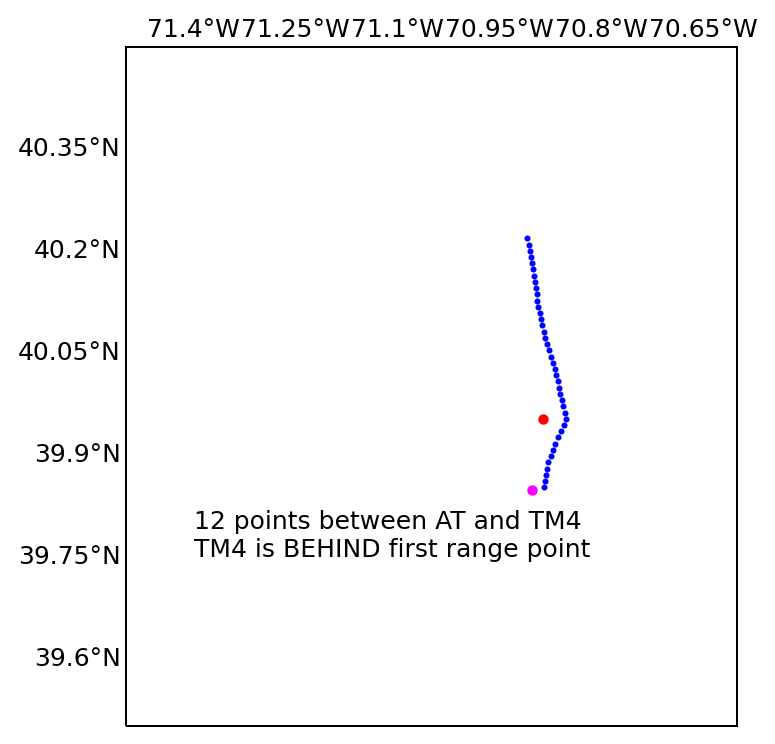

In [7]:
plt.figure(figsize=(5,5), dpi=180)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5,zorder=101)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, alpha=0)
gl.bottom_labels = False
gl.right_labels = False

ax.scatter(x=tm4[1], y=tm4[0], color='magenta', s=10,
           transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(x=at[1], y=at[0], color='r', s=10,
           transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(x=ds.lon, y=ds.lat, color='b', s=2,
           transform=ccrs.PlateCarree(), zorder=2)

plt.text(-71.4,39.75,'12 points between AT and TM4\nTM4 is BEHIND first range point',fontsize=10,\
        transform=ccrs.PlateCarree(),zorder=2)

ax.set_extent([-71.5, -70.6, 39.5, 40.5])
#ax.set_extent([-75.5, -70, 38, 41.75])

## Assumptions on data

we assume the data is on a flat line between the source and receiver

we assume the depth of the recevier since it was not disclosed

we assume the source is exactly on the first point of range

we assume the receiver is exactly on the 12th point of range

we throw away any data past the 12th point of range

we assign a value of mean sound speed on any point that had NaN as the sound speed value

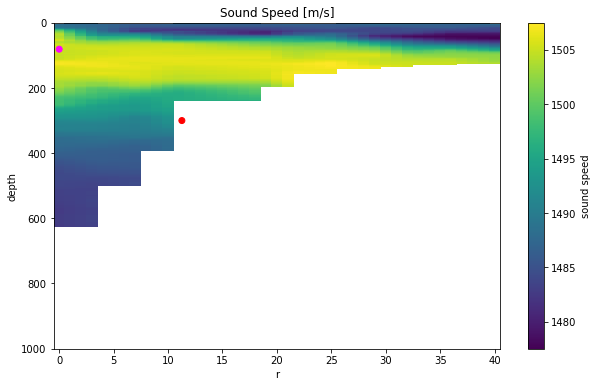

In [8]:
plt.figure(figsize=(10,6))
ds.ss.plot(yincrease=False)
plt.scatter([ds['range'].isel(r=0), ds['range'].isel(r=11)], [81., 300.] , color=['magenta', 'red'])
plt.title('Sound Speed [m/s]');

set dataset to first 12 ranges only

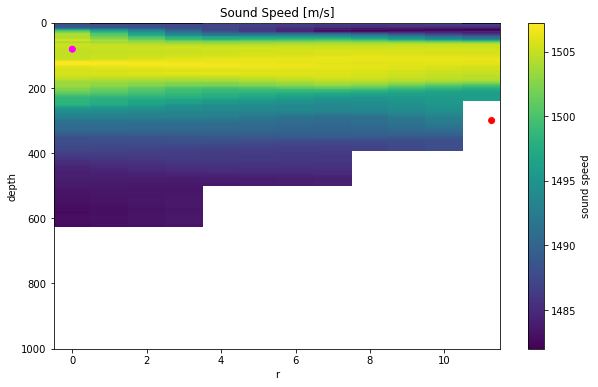

In [9]:
ds = ds.isel(r=slice(0,12))
plt.figure(figsize=(10,6))
ds.ss.plot(yincrease=False)
plt.scatter([ds['range'].isel(r=0), ds['range'].isel(r=11)], [81., 300.] , color=['magenta', 'red'])
plt.title('Sound Speed [m/s]');

# Write BELLHOP input files

# BTYFile


BELLHOP BTYFile is written as follows: 

`interpolation type`\
`number of bathymetry points, nBtyPts`\
`range(1)   depth(1)`\
`...`\
`range(nBtyPts)   depth(nBtyPts)`

In [10]:
fileBTY = runName + '.bty'
TypeBTY = "'L'"
nPtsBTY = len(ds.r)

dataBTY = np.column_stack([ds.range, ds.depth])

In [11]:
np.savetxt(filePath+fileBTY, dataBTY, fmt=['%0.1f', '%0.6f'], 
           header=TypeBTY + '\n' + str(nPtsBTY), comments='',
           delimiter='\t')

# Write SSPFile

BELLHOP SSPFile is written as follows: 

`number of SSP Ranges, SSP%Nr`\
`ranges in km`\
`SSP for each range at z(1)`\
`...`\
`SSP for each range at z(1001)`

In [12]:
fileSSP = runName + '.ssp'

nPtsSSP = len(ds.r)

### SSP nan values

there are nan values where the ssp could not be calculated for reasons not yet known by me. 

1) nan values below the bathymetry will be set to the groundfloor sound speed, 1600 m/s. \
2) nan values in the water column are replaced with the mean ssp in the domain. 

In [13]:
ds['ssmod1'] = ds.ss.where(ds.z < ds.depth, 1600.00)

In [14]:
ds['ssmod2'] = ds.ssmod1.where(ds.ssmod1.isnull() == False, 
                               ds.ss.mean(skipna=True) )

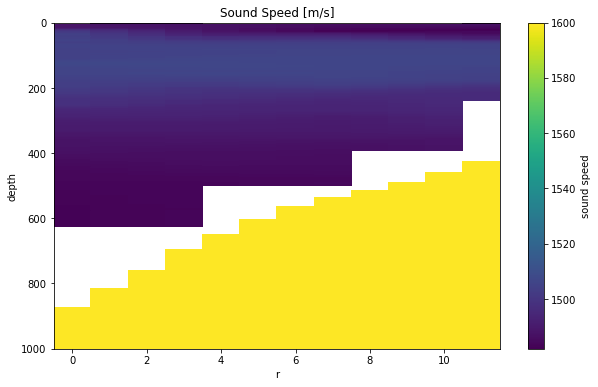

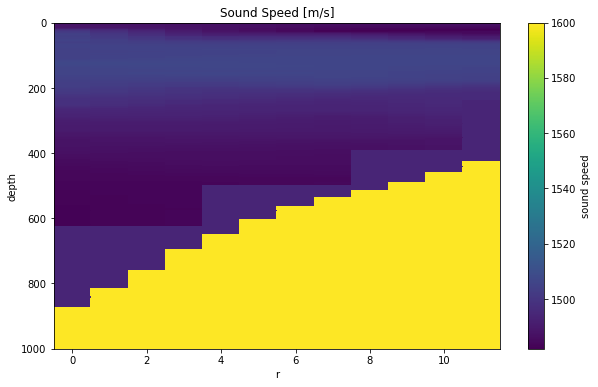

In [15]:
plt.figure(figsize=(10,6))
ds.ssmod1.plot(yincrease=False)
plt.title('Sound Speed [m/s]');
plt.show()

plt.figure(figsize=(10,6))
ds.ssmod2.plot(yincrease=False)
plt.title('Sound Speed [m/s]');
plt.show()

In [21]:
ds['range'].isel(r=11)

<xarray.DataArray 'range' ()>
array(11.271927)
Coordinates:
    r        int64 11
Attributes:
    long_name:  range
    unit:       km

In [16]:
dataSSP = np.vstack([dataBTY[:,0], ds.ssmod2])

In [17]:
np.savetxt(filePath+fileSSP, 
           dataSSP, fmt='%0.6f', 
           header=str(nPtsSSP), comments='',
           delimiter='\t')

# Write first column of SSP in ENVFile

BELLHOP ENVFile requires there be # of depths amount of rows with dummy SSP values to read in. It uses this to dtermine how big the SSPFile will be and will allocate memory for the SSP matrices with this.

In [18]:
dataENV = np.column_stack([ds.z, ds.ssmod2.isel(r=0)])

In [19]:
np.savetxt(filePath+runName+'-extension.env', 
           dataENV, fmt=['%0.1f', '%0.6f'], 
           delimiter='\t',
           newline='\t/\n')

<sub> Written by Ivana Escobar on July 2022